# Comparing Vascular Networks
Jocelyn Shen

###### In this notebook, I will be using SVMs, PCA, and logistic regression to compare networks

In [1]:
from itertools import combinations, chain, product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
%matplotlib inline
plt.style.use("fivethirtyeight")

### FUNCTIONS:

In [2]:
def process(filename, t):
    df = pd.read_csv(filename)
    df_null = df[df.isnull().any(axis=1)]
    df = df.drop(df_null.index)
    if(t == 0):
        df = pd.concat([df['beta.ave'], df['beta.diff'], df['gamma.ave'], df['gamma.diff'], df['group']], axis=1, 
                               keys=['beta.ave', 'beta.diff', 'gamma.ave', 'gamma.diff', 'group'])
        classes = df['group'].unique()
        all_dataframe_names = []
        all_dataframes = []
        x = 1
        for class_ in classes:
            globals()['df%s' % x] =df[df.group == class_].sample(frac=1).reset_index(drop = True)
            exec("all_dataframe_names.append(df" + str(x) + "['group'][0])")
            all_dataframes.append("df" + str(x))
            x = x + 1 
    else:
        df = pd.concat([df['beta'], df['gamma'], df['group']], axis=1, 
                               keys=['beta', 'gamma', 'group'])
        classes = df['group'].unique()
        all_dataframe_names = []
        all_dataframes = []
        x = 1
        for class_ in classes:
            globals()['df_%s' % x] =df[df.group == class_].sample(frac=1).reset_index(drop = True)
            exec("all_dataframe_names.append(df_" + str(x) + "['group'][0])")
            all_dataframes.append("df_" + str(x))
            x = x + 1 
    return all_dataframe_names, all_dataframes

In [3]:
# list_df is the list of dataframes that we are comparing
# p_train is percentage to take as training set
def train_test_split(list_df, p_train):
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    class_type = 0
    for dataframe in list_df:
        dataframe["type"] = np.asarray([class_type for x in range(0,dataframe.shape[0])])
        class_type = class_type + 1
        index = int(dataframe.shape[0]*(p_train/100.00))
        df_train = pd.concat([df_train, dataframe[:index]])
        df_test = pd.concat([df_test, dataframe[index:]])
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_test = df_test.sample(frac=1).reset_index(drop=True)
    return df_train, df_test

In [4]:
def plot(list_training_sets, x1, x2, name, l1, l2):
    c = 0
    figure = plt.figure(figsize = (20,15))
    ax = figure.add_subplot(1,1,1)
    ax.tick_params(axis = 'y', labelsize = 25)
    ax.tick_params(axis='x', labelsize=25)
    for training_set in list_training_sets:
        if(c==0):
            #plt.scatter(training_set[x1], training_set[x2], label = c, s = 40, facecolors='none', edgecolors = 'b')
            ax.scatter(training_set[x1], training_set[x2], label = l1, color = 'b', s = 150)
        if(c==1):
            #plt.scatter(training_set[x1], training_set[x2], label = c, s = 40, facecolors='none', edgecolors = 'r')
            ax.scatter(training_set[x1], training_set[x2], label = l2, color = 'r', s = 150)
        c = c + 1
    ax.legend(loc=1, prop={'size': 50})
    figure.savefig(str(name + ".png"), dpi = 300)
    plt.show()

### Comparing the Networks

The data I am using is from the AngiCAML version of Angicart software.
1. hht_master is data from 18 human head and torso images (ANIMAL)

2. mouselung_master is data from a mouse lung data (ANIMAL)

3. pinon_master is data from a Pinon tree/pine tree (PLANT)

4. ponderosa_master is data from a 5 sapling ponderosa pine trees (PLANT)

5. root_master is data from a large collection of clumps of tree roots (PLANT)  

6. treetips_master is data from a collection of 50cm long tree tip samples (PLANT) 
    
    a) 30 samples -- 5 individuals from 6 different species
    
    b) "class" distinguishes between angiosperm (AS, flowering plant), and gymnosperm (GS, non-flowering plant).

#### Load and Clean Datasets

In [5]:
all_df_names, all_dfs = process("filtered_grouped_asymmetric_scale_factor_values.csv", 0)
df1.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff,group
0,0.779348,0.380177,0.812970,0.521064,hht
1,0.951824,-0.007471,0.164472,0.113215,hht
2,0.881389,0.206872,0.544882,0.440219,hht
3,0.681721,-0.016966,0.391185,0.037997,hht
4,0.895425,-0.205646,1.512995,0.417565,hht


In [6]:
all_df_names_2, all_dfs_2 = process("filtered_grouped_symmetric_scale_factor_values.csv", 1)
df_1.head()

,beta,gamma,group
0,1.121524,4.023573,hht
1,0.979571,0.039326,hht
2,0.727900,0.572950,hht
3,0.642892,0.090328,hht
4,0.604090,0.548059,hht


#### Generate training and testing sets

1. df1: HHT
1. df2: Mouse
1. df3: Balsa
1. df4: Pinon
1. df5: Ponderosa
1. df6: GS Tips
1. df7: AS Tips
1. df8: Roots

#### Get all Combinations for Asymetric Values

In [7]:
repeated_tuples = []
for elem in all_df_names:
    repeated_tuples.append((elem, elem))
name_combinations = [p for p in product(all_df_names, repeat=2) if p not in repeated_tuples]
print(name_combinations)

[('hht', 'ml'), ('hht', 'balsa'), ('hht', 'pinon'), ('hht', 'ponderosa'), ('hht', 'GS Tips'), ('hht', 'AS Tips'), ('hht', 'roots'), ('ml', 'hht'), ('ml', 'balsa'), ('ml', 'pinon'), ('ml', 'ponderosa'), ('ml', 'GS Tips'), ('ml', 'AS Tips'), ('ml', 'roots'), ('balsa', 'hht'), ('balsa', 'ml'), ('balsa', 'pinon'), ('balsa', 'ponderosa'), ('balsa', 'GS Tips'), ('balsa', 'AS Tips'), ('balsa', 'roots'), ('pinon', 'hht'), ('pinon', 'ml'), ('pinon', 'balsa'), ('pinon', 'ponderosa'), ('pinon', 'GS Tips'), ('pinon', 'AS Tips'), ('pinon', 'roots'), ('ponderosa', 'hht'), ('ponderosa', 'ml'), ('ponderosa', 'balsa'), ('ponderosa', 'pinon'), ('ponderosa', 'GS Tips'), ('ponderosa', 'AS Tips'), ('ponderosa', 'roots'), ('GS Tips', 'hht'), ('GS Tips', 'ml'), ('GS Tips', 'balsa'), ('GS Tips', 'pinon'), ('GS Tips', 'ponderosa'), ('GS Tips', 'AS Tips'), ('GS Tips', 'roots'), ('AS Tips', 'hht'), ('AS Tips', 'ml'), ('AS Tips', 'balsa'), ('AS Tips', 'pinon'), ('AS Tips', 'ponderosa'), ('AS Tips', 'GS Tips'), ('

In [8]:
repeated_tuples = []
for elem in all_dfs:
    repeated_tuples.append((elem, elem))
combinations = [p for p in product(all_dfs, repeat=2) if p not in repeated_tuples]
print(combinations)
print(len(combinations))

[('df1', 'df2'), ('df1', 'df3'), ('df1', 'df4'), ('df1', 'df5'), ('df1', 'df6'), ('df1', 'df7'), ('df1', 'df8'), ('df2', 'df1'), ('df2', 'df3'), ('df2', 'df4'), ('df2', 'df5'), ('df2', 'df6'), ('df2', 'df7'), ('df2', 'df8'), ('df3', 'df1'), ('df3', 'df2'), ('df3', 'df4'), ('df3', 'df5'), ('df3', 'df6'), ('df3', 'df7'), ('df3', 'df8'), ('df4', 'df1'), ('df4', 'df2'), ('df4', 'df3'), ('df4', 'df5'), ('df4', 'df6'), ('df4', 'df7'), ('df4', 'df8'), ('df5', 'df1'), ('df5', 'df2'), ('df5', 'df3'), ('df5', 'df4'), ('df5', 'df6'), ('df5', 'df7'), ('df5', 'df8'), ('df6', 'df1'), ('df6', 'df2'), ('df6', 'df3'), ('df6', 'df4'), ('df6', 'df5'), ('df6', 'df7'), ('df6', 'df8'), ('df7', 'df1'), ('df7', 'df2'), ('df7', 'df3'), ('df7', 'df4'), ('df7', 'df5'), ('df7', 'df6'), ('df7', 'df8'), ('df8', 'df1'), ('df8', 'df2'), ('df8', 'df3'), ('df8', 'df4'), ('df8', 'df5'), ('df8', 'df6'), ('df8', 'df7')]
56


In [9]:
for i in range(0, len(combinations)):
    exec("train" + str(i) + ", test" + str(i)+ " = train_test_split([" + combinations[i][0] + "," + combinations[i][1] +"], 85)")
    exec("train" + str(i) +".to_csv('asTRAINING_SET_' + '" + name_combinations[i][0] + "_vs_" + name_combinations[i][1] + ".csv', sep = ',')")
    exec("test" + str(i) +".to_csv('asTESTING_SET' + '" + name_combinations[i][0] + "_vs_" + name_combinations[i][1] + ".csv', sep = ',')")

In [10]:
train0.head()

,beta.ave,beta.diff,gamma.ave,gamma.diff,group,type
0,2.144574,-0.283702,4.186127,2.744598,hht,0
1,0.611362,-0.166876,2.775294,1.476422,hht,0
2,0.533488,0.079495,1.460217,0.982994,hht,0
3,0.634940,0.106748,1.013229,0.099503,hht,0
4,1.292240,0.185557,3.499025,2.682528,ml,1


#### Get all Combinations for Symmetric Values

In [11]:
repeated_tuples_2 = []
for elem in all_dfs_2:
    repeated_tuples_2.append((elem, elem))
combinations_ = [p for p in product(all_dfs_2, repeat=2) if p not in repeated_tuples_2]
print(combinations_)

[('df_1', 'df_2'), ('df_1', 'df_3'), ('df_1', 'df_4'), ('df_1', 'df_5'), ('df_1', 'df_6'), ('df_1', 'df_7'), ('df_1', 'df_8'), ('df_2', 'df_1'), ('df_2', 'df_3'), ('df_2', 'df_4'), ('df_2', 'df_5'), ('df_2', 'df_6'), ('df_2', 'df_7'), ('df_2', 'df_8'), ('df_3', 'df_1'), ('df_3', 'df_2'), ('df_3', 'df_4'), ('df_3', 'df_5'), ('df_3', 'df_6'), ('df_3', 'df_7'), ('df_3', 'df_8'), ('df_4', 'df_1'), ('df_4', 'df_2'), ('df_4', 'df_3'), ('df_4', 'df_5'), ('df_4', 'df_6'), ('df_4', 'df_7'), ('df_4', 'df_8'), ('df_5', 'df_1'), ('df_5', 'df_2'), ('df_5', 'df_3'), ('df_5', 'df_4'), ('df_5', 'df_6'), ('df_5', 'df_7'), ('df_5', 'df_8'), ('df_6', 'df_1'), ('df_6', 'df_2'), ('df_6', 'df_3'), ('df_6', 'df_4'), ('df_6', 'df_5'), ('df_6', 'df_7'), ('df_6', 'df_8'), ('df_7', 'df_1'), ('df_7', 'df_2'), ('df_7', 'df_3'), ('df_7', 'df_4'), ('df_7', 'df_5'), ('df_7', 'df_6'), ('df_7', 'df_8'), ('df_8', 'df_1'), ('df_8', 'df_2'), ('df_8', 'df_3'), ('df_8', 'df_4'), ('df_8', 'df_5'), ('df_8', 'df_6'), ('df_8', 

In [13]:
for i in range(0, len(combinations_)):
    exec("train_" + str(i) + ", test_" + str(i)+ " = train_test_split([" + combinations_[i][0] + "," + combinations_[i][1] +"], 85)")
    exec("train_" + str(i) +".to_csv('symTRAINING_SET_' + '" + name_combinations[i][0] + "_vs_" + name_combinations[i][1] + ".csv', sep = ',')")
    exec("test_" + str(i) +".to_csv('symTESTING_SET' + '" + name_combinations[i][0] + "_vs_" + name_combinations[i][1] + ".csv', sep = ',')")

In [14]:
train_0.head()

,beta,gamma,group,type
0,0.540298,0.671344,hht,0
1,0.566246,0.698486,hht,0
2,0.662758,1.707467,hht,0
3,1.080267,1.120591,ml,1
4,0.892851,0.328305,hht,0


### Support Vector Machines

1. beta.ave, beta.diff
1. beta.ave, gamma.ave
1. beta.ave, gamma.diff
1. beta.diff, gamma.ave
1. beta.diff, gamma.diff
1. gamma.ave, gamma.diff
1. beta, gamma
1. beta.ave, beta.diff, gamma.ave, gamma.diff

In [15]:
# CREDITS: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
def plot_svc_decision_function(model, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--']) 
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [23]:
# training_x1 and training_x2 are beta.ave, gamma.ave, beta.diff, or gamma.diff
def SVM(training, testing, x1, x2, l1, l2, ker, deg):
    X = [training[x1].as_matrix(), training[x2].as_matrix()]
    X = np.transpose(X)
    Y = training['type'].as_matrix()
    clf = SVC(kernel=ker, degree = deg, probability = True)
    clf.fit(X, Y)
    #Plotting
    colors = {1:'r', 0:'b'}
    figure = plt.figure(figsize = (20,15))
    ax = figure.add_subplot(1,1,1)
    ax.tick_params(axis = 'y', labelsize = 25)
    ax.tick_params(axis='x', labelsize=25)
    ax.scatter(training[x1][training['type']==0], training[x2][training['type']==0], label = l1, color = 'b', s = 150)
    ax.scatter(training[x1][training['type']==1], training[x2][training['type']==1], label = l2, color = 'r', s = 150)
    ax.legend(loc=1, prop={'size': 50})
    plot_svc_decision_function(clf)
    figure.savefig("svm_" + l1 + "_vs_" + l2 +"_" + x1 + "_vs_" + x2 + ".png", dpi = 300)
    
    prob = clf.predict_proba(testing[[x1, x2]])
    prob_0 = []
    for n in prob:
        prob_0.append(n[0])
    testing['probabilities'] = prob_0 
    pred = clf.predict(testing[[x1, x2]])
    testing['prediction'] = pred 
    accuracy_score = clf.score(np.transpose([testing[x1].as_matrix(),testing[x2].as_matrix()]), testing['type'].as_matrix())
    print(accuracy_score)
    testing = testing[[x1, x2, 'group', 'type', 'probabilities', 'prediction']]
    testing.to_csv("svm_" + l1 + "_vs_" + l2 +"_" + x1 + "_vs_" + x2 + str(accuracy_score) + ".csv", sep = ',')
    return testing

#### Generate SVM model for all pairwise combinatioins

In [ ]:
for i in range(0, len(name_combinations)):
    exec("SVM(train_" + str(i) + ", test_" + str(i) + ", 'beta', 'gamma', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "', 'poly', 2)")
for i in range(0, len(name_combinations)):
    exec("SVM(train" + str(i) + ", test" + str(i) + ", 'beta.ave', 'beta.diff', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "', 'poly', 2)")
for i in range(0, len(name_combinations)):
    exec("SVM(train" + str(i) + ", test" + str(i) + ", 'beta.ave', 'gamma.ave', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "', 'poly', 2)")
for i in range(0, len(name_combinations)):
    exec("SVM(train" + str(i) + ", test" + str(i) + ", 'beta.ave', 'gamma.diff', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "', 'poly', 2)")
for i in range(0, len(name_combinations)):
    exec("SVM(train" + str(i) + ", test" + str(i) + ", 'beta.diff', 'gamma.ave', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "', 'poly', 2)")
for i in range(0, len(name_combinations)):
    exec("SVM(train" + str(i) + ", test" + str(i) + ", 'beta.diff', 'gamma.diff', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "', 'poly', 2)")
for i in range(0, len(name_combinations)):
    exec("SVM(train" + str(i) + ", test" + str(i) + ", 'gamma.ave', 'gamma.diff', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "', 'poly', 2)")

0.581818181818


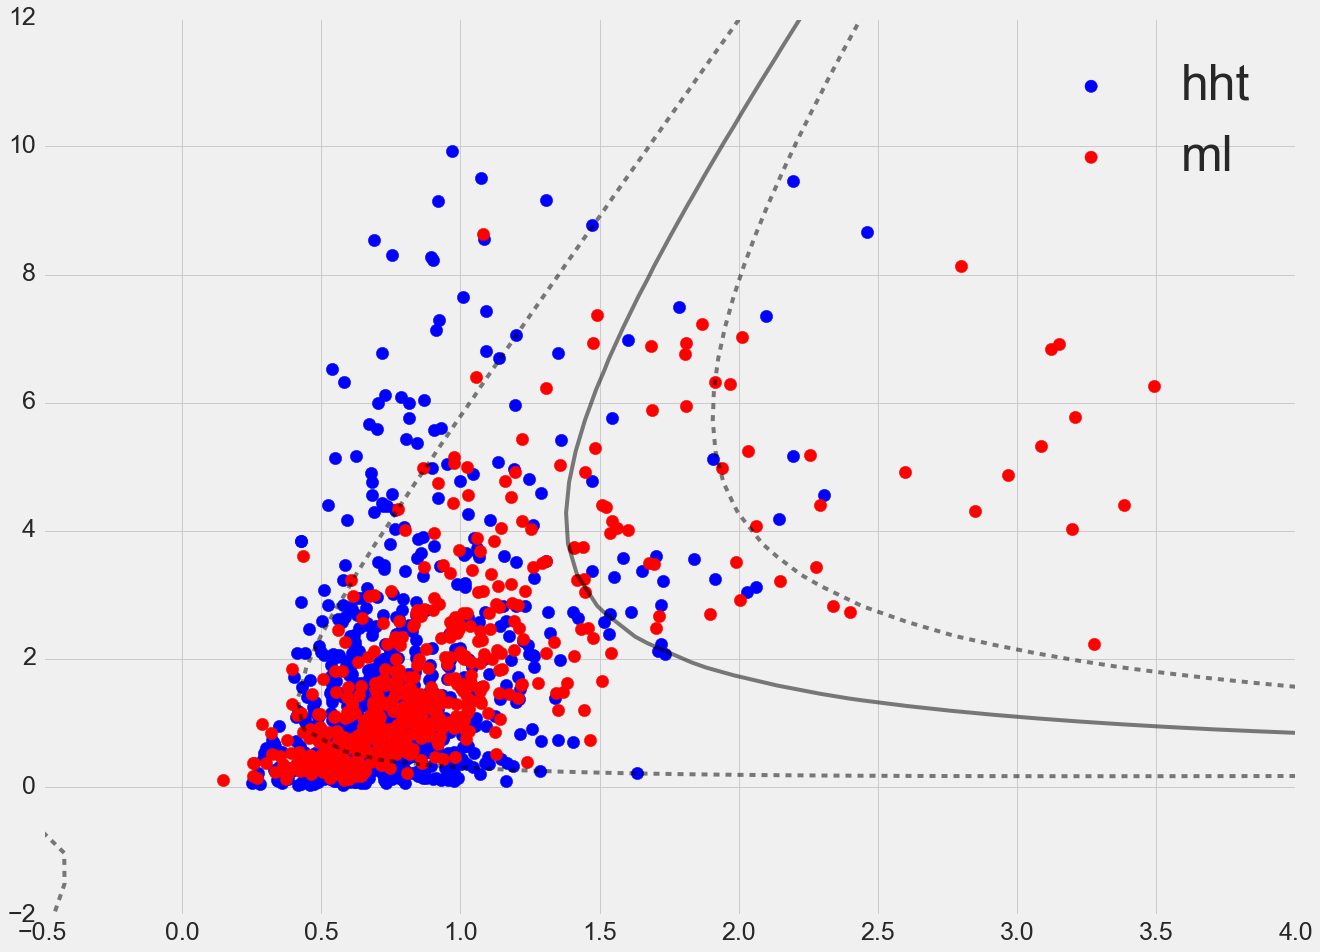

In [24]:
t0 = SVM(train0, test0, 'beta.ave', 'gamma.ave',name_combinations[0][0], name_combinations[0][1], 'poly', 2)

In [17]:
t1 = SVM(train47, test47, 'beta.ave', 'gamma.ave', name_combinations[47][0], name_combinations[47][1], 'poly', 2)

0.666666666667


### Logistic Regression

In [21]:
colors = {1:'r', 0:'b'}
def LogReg(training, testing, x1, x2, l1, l2, func):
    X_data = None
    y = training['type']
    test = None
    y_test = testing['type']
    x_axis_name = x1
    y_axis_name = x2
    if func == 'poly_2':
        training["X1^2"] = training[x1]**2
        training["X2^2"] = training[x2]**2
        training["XY"] = training[x1]*training[x2]
        testing["X1^2"] = testing[x1]**2
        testing["X2^2"] = testing[x2]**2
        testing["XY"] = testing[x1]*testing[x2]
        X_data = training[[x1, x2, "X1^2", "X2^2", "XY"]]
        test = testing[[x1, x2, "X1^2", "X2^2", "XY"]]
    #Create grid
    logreg = LogisticRegression()
    model = logreg.fit(X_data,y)
    GRANULARITY = 50
    x1_min, x1_max, x2_min, x2_max = (training[x_axis_name].min(),training[x_axis_name].max(),training[y_axis_name].min(),training[y_axis_name].max())
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),np.linspace(x2_min, x2_max, GRANULARITY))
    xx1_col = xx1.ravel()
    xx2_col = xx2.ravel()
    #Predict
    X_columns = None
    if func == "lin":
        X_columns = np.c_[xx1_col, xx2_col]   
    if func == "poly_2":
        X_columns = np.c_[xx1_col, xx2_col, xx1_col**2, xx2_col**2, xx1_col*xx2_col]
    if func == "eli":
        X_columns = np.c_[xx1_col, xx2_col, xx1_col**2, xx2_col**2]
    if func == "rec":
        X_columns = np.c_[xx1_col, xx2_col, 1/(xx2_col)]
    if func == "exp":
        X_columns = np.c_[xx1_col, xx2_col, np.exp((-1)*xx2_col)]
    if func == "trig":
        X_columns = np.c_[xx1_col, xx2_col, np.sin(xx1_col), np.cos(xx2_col)]
    yy = model.predict_proba(X_columns).T[0] 
    yy = yy.reshape(xx1.shape)
    #Plot figure
    figure = plt.figure(figsize = (20,15)) 
    ax = figure.add_subplot(1,1,1)
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    ax.tick_params(axis = 'y', labelsize = 25)
    ax.tick_params(axis='x', labelsize=25)
    #Plot contours
    ax.contour(xx1, xx2, yy, levels=[.5], colors=['c'])
    contour = ax.contourf(xx1, xx2, yy, 100, cmap="RdBu",vmin=0, vmax=1)
    ax_c = figure.colorbar(contour)
    #Plot scatter plot of original dataset
    #ax.scatter(training[x_axis_name],training[y_axis_name], c = training['type'].map(colors), s = 100) 
    ax.scatter(training[x1][training['type']==0], training[x2][training['type']==0], label = l1, color = 'b', s = 150)
    ax.scatter(training[x1][training['type']==1], training[x2][training['type']==1], label = l2, color = 'r', s = 150)
    ax.legend(loc=1, prop={'size': 50})
    figure.savefig("logreg_" + l1 + "_vs_" + l2 +"_" + x1 + "_vs_" + x2 + ".png", dpi = 300)
    plt.show()
    
    #Print accuracy score
    accuracy_score = logreg.score(test,y_test)
    print(accuracy_score)
    prob = model.predict_proba(test)
    prob_0 = []
    for n in prob:
        prob_0.append(n[0])
    pred = model.predict(test)
    testing['probabilities'] = prob_0 
    testing['prediction'] = pred 
    testing = testing[[x1, x2, 'group', 'type', 'probabilities', 'prediction']]
    testing.to_csv("logreg_" + l1 + "_vs_" + l2 +"_" + x1 + "_vs_" + x2 + str(accuracy_score) +  ".csv", sep = ',')
    return testing

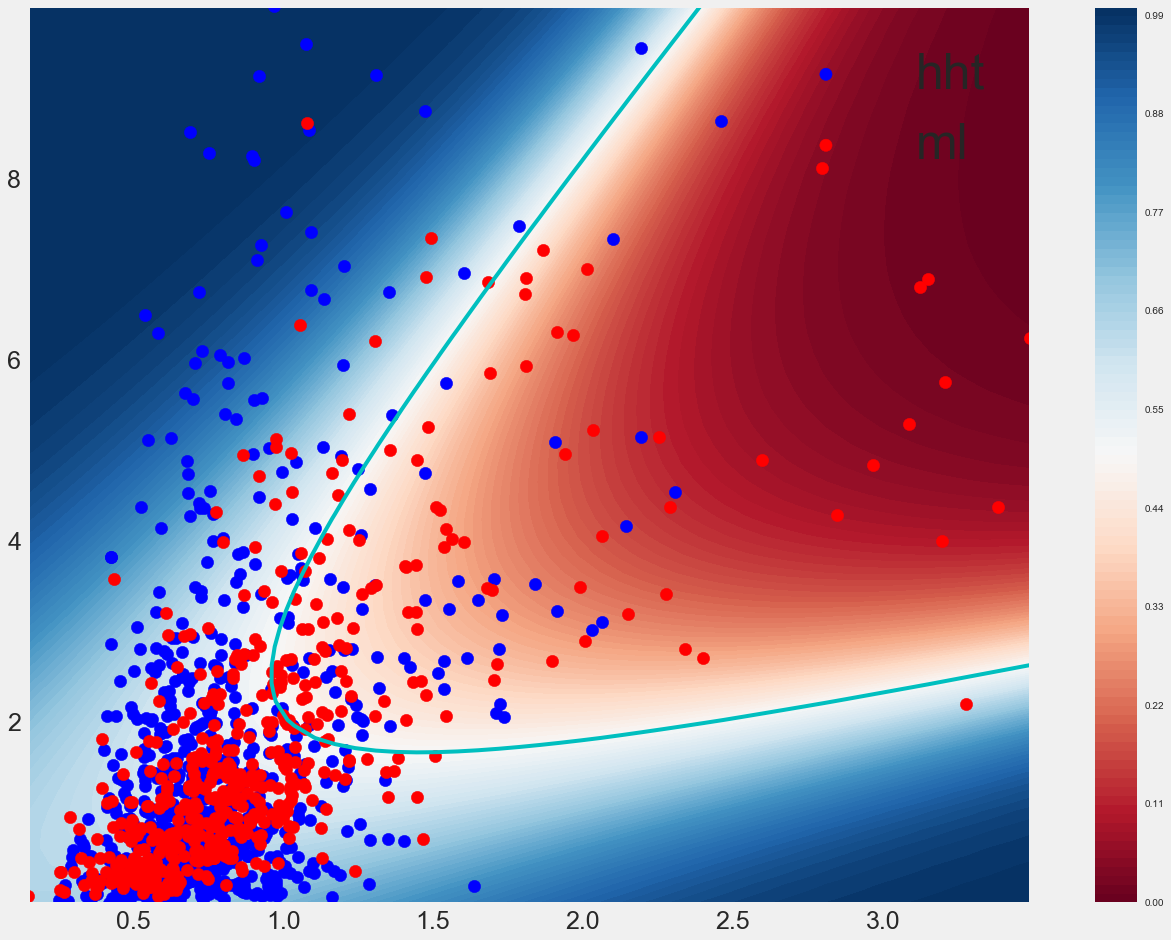

0.595454545455


In [22]:
t3 = LogReg(train0, test0, 'beta.ave', 'gamma.ave',name_combinations[0][0], name_combinations[0][1], 'poly_2')

In [20]:
t4 = LogReg(train47, test47, 'beta.ave', 'gamma.ave', name_combinations[47][0], name_combinations[47][1], 'poly_2')

0.666666666667


#### Generate Logistic Regression model for all pairwise combinations

In [ ]:
for i in range(0, len(name_combinations)):
    exec("LogReg(train_" + str(i) + ", test_" + str(i) + ", 'beta', 'gamma', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "' , 'poly_2')")
for i in range(0, len(name_combinations)):
    exec("LogReg(train" + str(i) + ", test" + str(i) + ", 'beta.ave', 'beta.diff', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "' , 'poly_2')")
for i in range(0, len(name_combinations)):
    exec("LogReg(train" + str(i) + ", test" + str(i) + ", 'beta.ave', 'gamma.ave', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "' , 'poly_2')")
for i in range(0, len(name_combinations)):
    exec("LogReg(train" + str(i) + ", test" + str(i) + ", 'beta.ave', 'gamma.diff', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "' , 'poly_2')")
for i in range(0, len(name_combinations)):
    exec("LogReg(train" + str(i) + ", test" + str(i) + ", 'beta.diff', 'gamma.ave', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "' , 'poly_2')")
for i in range(0, len(name_combinations)):
    exec("LogReg(train" + str(i) + ", test" + str(i) + ", 'beta.diff', 'gamma.diff', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "' , 'poly_2')")
for i in range(0, len(name_combinations)):
    exec("LogReg(train" + str(i) + ", test" + str(i) + ", 'gamma.ave', 'gamma.diff', '" + name_combinations[i][0] + "', '" + name_combinations[i][1] + "' , 'poly_2')")